In [1]:
import os
from google.oauth2 import service_account
import pandas as pd

# Path to your service account JSON key file
credentials_path = '../sa.json'

# Set the environment variable
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path

credentials = service_account.Credentials.from_service_account_file(
    credentials_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

from google.cloud import bigquery

# Initialize a client
client = bigquery.Client(credentials=credentials, project = "research-1049")

# Create job configuration to specify legacy SQL
job_config = bigquery.QueryJobConfig(job_timeout_ms=5000*10)
job_config.use_legacy_sql = False  # This is the key setting for legacy SQL

def run_query(query):
    query_job = client.query(query, job_config=job_config)  
    df = query_job.to_dataframe()
    return df

query = """
SELECT * FROM `research-1049.BRYAN.EVENTAUG_20250610_00_04` 
WHERE total > 5
"""

import time

start_time = time.time()
df = run_query(query)
print("--- %s seconds ---" % (time.time() - start_time))

/opt/conda/envs/aiFraud/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


--- 1382.2831013202667 seconds ---


In [2]:
df['fraudRate'] = df['fraudTotal'] / df['total']
df = df.rename(columns={'ip': 'IP'})


In [9]:
columns_to_stay_ip = [
    'IP',
    # 'total',
    'totalPerDevice',
    # 'fraudTotal',
    # 'ipMaxMinutesActive',
    # 'ipMinMinutesActive',
    'ipAvgMinutesActive',
    'ipMinutesActivePerDay50',
    'ipMinutesActivePerDay90',
    'ipMinutesActivePerDay99',
    # 'deviceIdMaxMinutesActive',
    'deviceIdMinMinutesActive',
    'deviceIdAvgMinutesActive',
    'deviceIdMinutesActivePerDay50',
    'deviceIdMinutesActivePerDay90',
    'deviceIdMinutesActivePerDay99',
    # 'maxIpMinutesActive',
    # 'minIpMinutesActive',
    # 'avgIpMinutesActive',
    # 'ipMinutesActive50',
    # 'ipMinutesActive90',
    # 'ipMinutesActive99',
    'b3',
    'ttlQ50',
    'ttlQ99',
    # 'totalIPs',
    # 'impsPerIp',
    # 'totalCookies',
    # 'totalUAs',
    # 'totalOrgs',
    'xDeviceUaImpressionRatio',
    'ipMismatchRatio',
    'noKv4InXffRatio',
    'nullDeviceIdRatio',
    # 'uaDiscrepancy',
    # 'totalApps',
    # 'totalDomains',
    # 'totalReferrers',
    # 'totalCountries',
    # 'totalSeconds',
    # 'totalMinutes',
    # 'totalHours',
    # 'totalDevices',
    # 'deviceToIpRatio',
    # 'deviceToAppRatio',
    # 'ipsToOrgRatio',
    # 'uaToIpRatio',
    # 'minDevicePerAppIP',
    # 'avgDevicePerAppIP',
    # # 'maxDevicePerAppIP',
    # 'DevicePerAppIPQ50',
    # 'DevicePerAppIPQ90',
    # 'DevicePerAppIPQ99',
    'minAppsPerDevice',
    'maxAppsPerDevice',
    'avgAppsPerDevice',
    'totalAppsQ50',
    'totalAppsQ90',
    'totalAppsQ99',
    # 'fraudRate',
]

df_clean = df[columns_to_stay_ip]
df_wo_na = df.dropna()
df_clean.dropna(inplace=True)

/var/tmp/ipykernel_1339381/2574710076.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.dropna(inplace=True)


## Corr

Correlation of 'total' with other columns:
ipMinutesActivePerDay50       :   0.7985
ipAvgMinutesActive            :   0.7946
ipMinutesActivePerDay99       :   0.6249
ipMinutesActivePerDay90       :   0.6176
deviceIdMinutesActivePerDay99 :   0.0476
maxAppsPerDevice              :   0.0318
deviceIdMinutesActivePerDay90 :   0.0244
totalPerDevice                :   0.0241
deviceIdAvgMinutesActive      :   0.0158
totalAppsQ99                  :   0.0155
deviceIdMinutesActivePerDay50 :   0.0089
deviceIdMinMinutesActive      :   0.0085
ipMismatchRatio               :   0.0073
nullDeviceIdRatio             :  -0.0062
ttlQ99                        :   0.0062
totalAppsQ50                  :  -0.0061
b3                            :   0.0056
minAppsPerDevice              :  -0.0055
totalAppsQ90                  :   0.0026
avgAppsPerDevice              :  -0.0014
ttlQ50                        :  -0.0011
xDeviceUaImpressionRatio      :  -0.0003
noKv4InXffRatio               :  -0.0001


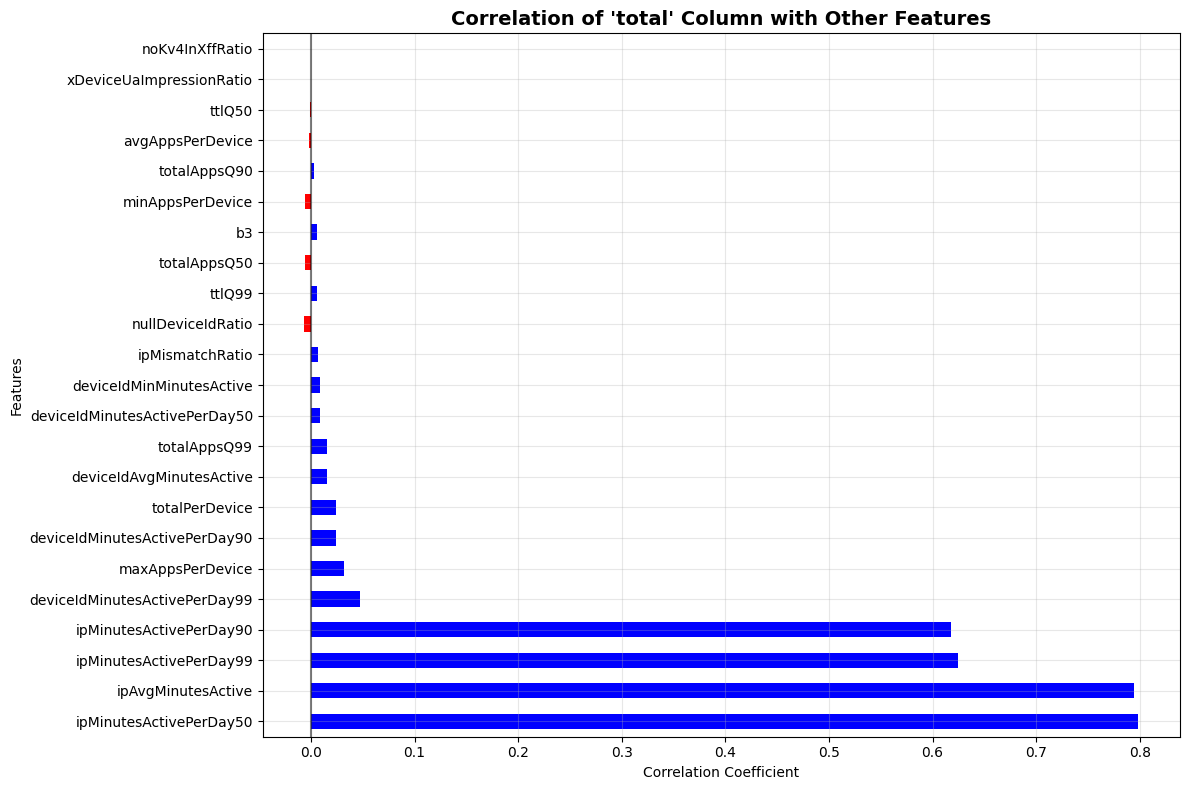

In [8]:
# Calculate correlation of 'total' column with all other numeric columns (excluding 'IP')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get all columns except 'IP' and 'total'
numeric_columns = [col for col in df_clean.columns if col not in ['IP', 'total']]

# Calculate correlations with 'total' column
correlations = df_clean[['total'] + numeric_columns].corr()['total'].drop('total')

# Sort correlations by absolute value (strongest correlations first)
correlations_sorted = correlations.reindex(correlations.abs().sort_values(ascending=False).index)

print("Correlation of 'total' with other columns:")
print("=" * 50)
for col, corr in correlations_sorted.items():
    print(f"{col:<30}: {corr:>8.4f}")

# Create a visualization
plt.figure(figsize=(12, 8))
correlations_sorted.plot(kind='barh', color=['red' if x < 0 else 'blue' for x in correlations_sorted])
plt.title("Correlation of 'total' Column with Other Features", fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()

## ML

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
# import cudf
# import cupy as cp
# from numba import cuda
# import networkx as nx
import time

# Timer decorator for performance monitoring
def timer(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"{func.__name__} took {end - start:.4f} seconds")
        return result
    return wrapper

class GraphAnomalyDetector:
    def __init__(self, appId_IP_df, use_gpu=True):
        self.appId_IP_df = appId_IP_df
        self.use_gpu = use_gpu
        self.results = {}
        
        # Initialize GPU if available
        if self.use_gpu:
            pass
            # try:
            #     self.gpu_df = cudf.DataFrame.from_pandas(df)
            #     self.gpu_appId_df = cudf.DataFrame.from_pandas(appId_df)
            #     print("GPU acceleration enabled")
            # except:
            #     print("GPU initialization failed, falling back to CPU")
            #     self.use_gpu = False

    @timer
    def create_ip_appid_edges(self):
        appid_IP_features = self.appId_IP_df.copy()
        
        # Fill NaN values 
        appid_IP_features = appid_IP_features.fillna(0)
        
        # Drop non-numeric columns for anomaly detection
        feature_cols = appid_IP_features.drop(['IP'], axis=1).columns
        
        return appid_IP_features, feature_cols
        
    
    @timer
    def create_deviceid_appid_edges(self):
        """Create features for deviceId-appId edges"""
        pass
    
    @timer
    def detect_anomalies(self, features_df, feature_cols, anomaly_type, contamination=0.3):
        """Detect anomalies using Isolation Forest and LOF"""
        # Extract features for anomaly detection
        X = features_df[feature_cols].fillna(0).values
        
        # Handle sparse data
        X = np.nan_to_num(X)
        
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
        # Isolation Forest
        iso_forest = IsolationForest(contamination=0.02, random_state=42, n_jobs=-1)
        iso_forest_scores = iso_forest.fit_predict(X)
        iso_forest_anomalies = iso_forest_scores == -1
        

        # Combine results (an edge is anomalous if both methods flag it)
        combined_anomalies = iso_forest_anomalies # & lof_anomalies
        
        # Store results
        result_df = features_df.copy()
        result_df['is_anomaly'] = combined_anomalies
        result_df['anomaly_score'] = iso_forest.decision_function(X)

        
        # For interpretability, calculate feature importance
        if np.any(combined_anomalies):
            normal_data = X[~combined_anomalies]
            anomaly_data = X[combined_anomalies]
            
            # Calculate z-scores for each feature in anomalies
            normal_mean = np.mean(normal_data, axis=0)
            normal_std = np.std(normal_data, axis=0) + 1e-5
            z_scores = np.abs((anomaly_data - normal_mean) / normal_std)
            
            # Average z-scores across anomalies
            feature_importance = np.mean(z_scores, axis=0)
            
            # Map feature importance back to feature names
            importance_dict = dict(zip(feature_cols, feature_importance))
            top_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:5]
            
            # Add top anomalous features for each anomaly
            result_df['anomaly_reason'] = 'Normal'
            for idx in np.where(combined_anomalies)[0]:
                if idx < len(result_df):
                    anomaly_z_scores = np.abs((X[idx] - normal_mean) / normal_std)
                    top_anomaly_features = sorted(zip(feature_cols, anomaly_z_scores), key=lambda x: x[1], reverse=True)[:3]
                    result_df.iloc[idx, result_df.columns.get_loc('anomaly_reason')] = ', '.join([f"{feat}: {score:.2f}σ" for feat, score in top_anomaly_features])
        else:
            result_df['anomaly_reason'] = 'Normal'
        
        print(f"Found {sum(combined_anomalies)} anomalies out of {len(features_df)} {anomaly_type}")
        return result_df, iso_forest
    

    @timer
    def run(self):
        """Run the entire anomaly detection pipeline"""
        # Create edge features
        ip_appid_features, ip_appid_cols = self.create_ip_appid_edges()
        # deviceid_appid_features, deviceid_appid_cols = self.create_deviceid_appid_edges()
        
        # Detect anomalies
        ip_appid_results, model = self.detect_anomalies(ip_appid_features, ip_appid_cols, "IP-appId edges")
        
        # Store results
        self.results = {
            'ip_anomalies_result': ip_appid_results,
            'ip_anomalies_model': model
        }
        
        return self.results


In [11]:
detector = GraphAnomalyDetector(df_clean, use_gpu=True)
results = detector.run()

create_ip_appid_edges took 2.1040 seconds
Found 126058 anomalies out of 6303239 IP-appId edges
detect_anomalies took 122.0836 seconds
run took 124.2395 seconds


In [12]:
results_df = results['ip_anomalies_result']
results_model = results['ip_anomalies_model']

In [13]:
# metrics_df indexed by appId
metrics_df = df_wo_na.set_index('IP')[[
    'fraudTotal',
    'fraudRate',
]]
# join preserves the original row‐index
results_df = results_df.join(metrics_df, on='IP')


In [14]:
avg_fraud_rate_anomaly = results_df[results_df['is_anomaly'] == True]['fraudRate'].mean()

avg_fraud_rate_normal = results_df[results_df['is_anomaly'] == False]['fraudRate'].mean()

print(f"Average fraud rate when is_anomaly is TRUE: {avg_fraud_rate_anomaly:.4f}")
print(f"Average fraud rate when is_anomaly is FALSE: {avg_fraud_rate_normal:.4f}")

Average fraud rate when is_anomaly is TRUE: 0.2330
Average fraud rate when is_anomaly is FALSE: 0.1227


In [15]:
X = df_clean.drop(columns=['IP'])
X.columns

Index(['totalPerDevice', 'ipAvgMinutesActive', 'ipMinutesActivePerDay50',
       'ipMinutesActivePerDay90', 'ipMinutesActivePerDay99',
       'deviceIdMinMinutesActive', 'deviceIdAvgMinutesActive',
       'deviceIdMinutesActivePerDay50', 'deviceIdMinutesActivePerDay90',
       'deviceIdMinutesActivePerDay99', 'b3', 'ttlQ50', 'ttlQ99',
       'xDeviceUaImpressionRatio', 'ipMismatchRatio', 'noKv4InXffRatio',
       'nullDeviceIdRatio', 'minAppsPerDevice', 'maxAppsPerDevice',
       'avgAppsPerDevice', 'totalAppsQ50', 'totalAppsQ90', 'totalAppsQ99'],
      dtype='object')

In [16]:
results_df_anomaly = results_df[results_df["is_anomaly"]==True]
results_df_anomaly

,IP,totalPerDevice,ipAvgMinutesActive,ipMinutesActivePerDay50,ipMinutesActivePerDay90,ipMinutesActivePerDay99,deviceIdMinMinutesActive,deviceIdAvgMinutesActive,deviceIdMinutesActivePerDay50,deviceIdMinutesActivePerDay90,...,maxAppsPerDevice,avgAppsPerDevice,totalAppsQ50,totalAppsQ90,totalAppsQ99,is_anomaly,anomaly_score,anomaly_reason,fraudTotal,fraudRate
36,49.145.165.232,107.0,2.018868,2,3,5,53,53.0,53,53,...,1,1.000000,1,1,1,True,-0.159101,"totalPerDevice: 20.40σ, deviceIdMinutesActiveP...",0,0.0
52,99.7.190.124,46.0,1.352941,1,2,4,34,34.0,34,34,...,1,1.000000,1,1,1,True,-0.030626,"deviceIdMinMinutesActive: 9.24σ, deviceIdMinut...",15,0.326087
97,184.166.56.69,68.0,1.360000,1,2,4,50,50.0,50,50,...,1,1.000000,1,1,1,True,-0.086013,"deviceIdMinutesActivePerDay50: 13.94σ, deviceI...",4,0.058824
185,114.122.21.88,6.2,1.291667,1,2,4,1,4.8,1,20,...,5,3.222222,5,5,5,True,-0.057388,"totalAppsQ50: 12.31σ, avgAppsPerDevice: 6.55σ,...",8,0.258065
226,173.16.35.47,63.0,1.536585,1,2,5,41,41.0,41,41,...,1,1.000000,1,1,1,True,-0.070847,"totalPerDevice: 11.65σ, deviceIdMinMinutesActi...",63,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6303200,35.150.43.167,17.0,1.307692,1,2,3,13,13.0,13,13,...,3,3.000000,3,3,3,True,-0.027197,"minAppsPerDevice: 8.16σ, totalAppsQ50: 6.02σ, ...",14,0.823529
6303201,39.125.252.14,13.0,1.000000,1,1,1,13,13.0,13,13,...,3,3.000000,3,3,3,True,-0.014999,"minAppsPerDevice: 8.16σ, totalAppsQ50: 6.02σ, ...",11,0.846154
6303214,38.81.81.123,16.6,1.360656,1,2,4,1,13.0,5,51,...,4,2.555556,2,4,4,True,-0.053541,"deviceIdMinutesActivePerDay90: 9.82σ, deviceId...",3,0.036145
6303217,35.150.169.53,17.0,1.307692,1,2,4,13,13.0,13,13,...,3,3.000000,3,3,3,True,-0.020080,"minAppsPerDevice: 8.16σ, totalAppsQ50: 6.02σ, ...",11,0.647059


In [17]:
import pandas as pd
import numpy as np
from scipy import stats

def isolation_forest_to_probability(anomaly_scores, method='severity_ranking'):
    """
    Convert Isolation Forest anomaly scores to probabilities in range [0.5, 1]
    
    Parameters:
    anomaly_scores: array of isolation forest scores (negative values)
    method: approach to calculate probability
    
    Returns:
    probabilities: array of values between 0.5 and 1
    """
    
    if method == 'severity_ranking':
        """
        RECOMMENDED: Rank anomalies by severity within the anomaly set
        Most negative (severe) anomaly gets highest probability
        """
        # More negative = more anomalous = higher probability
        # Invert so more negative becomes higher value
        inverted_scores = -anomaly_scores  # Convert to positive, more positive = more anomalous
        
        # Min-max scale to [0,1]
        min_score = inverted_scores.min()
        max_score = inverted_scores.max()
        
        if max_score == min_score:
            return np.ones(len(anomaly_scores)) * 0.75  # Return 0.75 instead of 0.5
        
        prob_0_to_1 = (inverted_scores - min_score) / (max_score - min_score)
        # Scale from [0,1] to [0.5,1]
        prob = 0.5 + 0.5 * prob_0_to_1
        return prob
    
    elif method == 'percentile_within_anomalies':
        """
        Use percentile ranking within the anomaly group
        """
        # More negative = higher rank = higher probability
        inverted_scores = -anomaly_scores
        ranks = stats.rankdata(inverted_scores, method='average')
        prob_0_to_1 = (ranks - 1) / (len(ranks) - 1)
        # Scale from [0,1] to [0.5,1]
        prob = 0.5 + 0.5 * prob_0_to_1
        return prob
    
    elif method == 'exponential_severity':
        """
        Exponential transformation emphasizing most severe anomalies
        """
        inverted_scores = -anomaly_scores
        min_score = inverted_scores.min()
        max_score = inverted_scores.max()
        
        if max_score == min_score:
            return np.ones(len(anomaly_scores)) * 0.75
        
        normalized = (inverted_scores - min_score) / (max_score - min_score)
        prob_0_to_1 = (np.exp(2 * normalized) - 1) / (np.exp(2) - 1)  # Scale to [0,1]
        # Scale from [0,1] to [0.5,1]
        prob = 0.5 + 0.5 * prob_0_to_1
        return prob
    
    elif method == 'sigmoid_centered':
        """
        Sigmoid transformation centered around median anomaly
        """
        inverted_scores = -anomaly_scores
        median_score = np.median(inverted_scores)
        std_score = inverted_scores.std()
        
        if std_score == 0:
            return np.ones(len(anomaly_scores)) * 0.75
        
        # Center around median, scale by std
        normalized = (inverted_scores - median_score) / std_score
        prob_0_to_1 = 1 / (1 + np.exp(-2 * normalized))  # Sigmoid with scaling factor 2
        # Scale from [0,1] to [0.5,1]
        prob = 0.5 + 0.5 * prob_0_to_1
        return prob
    
    elif method == 'threshold_based':
        """
        Create probability tiers based on severity thresholds
        """
        inverted_scores = -anomaly_scores
        
        # Define percentile thresholds
        p75 = np.percentile(inverted_scores, 75)  # Top 25% most severe
        p50 = np.percentile(inverted_scores, 50)  # Top 50% most severe
        p25 = np.percentile(inverted_scores, 25)  # Bottom 25% least severe
        
        prob = np.zeros(len(inverted_scores))
        prob[inverted_scores >= p75] = 0.95  # Highest severity (was 0.9)
        prob[(inverted_scores >= p50) & (inverted_scores < p75)] = 0.8   # High severity (was 0.7)
        prob[(inverted_scores >= p25) & (inverted_scores < p50)] = 0.7   # Medium severity (was 0.5)
        prob[inverted_scores < p25] = 0.6    # Lower severity (was 0.3)
        
        return prob

In [18]:
probs = isolation_forest_to_probability(results_df_anomaly["anomaly_score"], "severity_ranking")
results_df_anomaly["probability"] = probs
results_df_anomaly.sort_values("probability", ascending=False)

/var/tmp/ipykernel_1339381/2128890942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_anomaly["probability"] = probs


,IP,totalPerDevice,ipAvgMinutesActive,ipMinutesActivePerDay50,ipMinutesActivePerDay90,ipMinutesActivePerDay99,deviceIdMinMinutesActive,deviceIdAvgMinutesActive,deviceIdMinutesActivePerDay50,deviceIdMinutesActivePerDay90,...,avgAppsPerDevice,totalAppsQ50,totalAppsQ90,totalAppsQ99,is_anomaly,anomaly_score,anomaly_reason,fraudTotal,fraudRate,probability
4760534,73.48.122.146,696.0,9.157895,9,14,24,76,76.0,76,76,...,5.0,5,5,5,True,-2.169595e-01,"totalPerDevice: 137.57σ, deviceIdMinutesActive...",696,1.0,1.000000
2809546,146.70.249.226,167.0,4.771429,3,9,36,35,35.0,35,35,...,9.0,9,9,9,True,-2.143580e-01,"minAppsPerDevice: 33.26σ, totalPerDevice: 32.3...",167,1.0,0.994005
3794557,172.248.93.214,64.0,1.000000,1,1,1,64,64.0,64,64,...,4.0,4,4,4,True,-2.138163e-01,"deviceIdMinutesActivePerDay50: 18.06σ, deviceI...",0,0.0,0.992756
3534849,122.44.0.146,58.0,1.054545,1,1,2,55,55.0,55,55,...,6.0,6,6,6,True,-2.120811e-01,"minAppsPerDevice: 20.71σ, totalAppsQ50: 15.45σ...",47,0.810345,0.988757
287917,66.214.184.229,48.0,1.170732,1,2,2,41,41.0,41,41,...,7.0,7,7,7,True,-2.061589e-01,"minAppsPerDevice: 24.89σ, totalAppsQ50: 18.59σ...",48,1.0,0.975109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3056363,50.103.240.238,26.0,1.130435,1,2,2,23,23.0,23,23,...,2.0,2,2,2,True,-1.611686e-06,"deviceIdMinMinutesActive: 6.01σ, deviceIdMinut...",5,0.192308,0.500002
1387263,98.113.81.249,27.0,1.173913,1,2,2,23,23.0,23,23,...,2.0,2,2,2,True,-1.611686e-06,"deviceIdMinMinutesActive: 6.01σ, deviceIdMinut...",18,0.666667,0.500002
3664741,107.219.33.102,27.0,1.173913,1,2,2,23,23.0,23,23,...,2.0,2,2,2,True,-1.611686e-06,"deviceIdMinMinutesActive: 6.01σ, deviceIdMinut...",0,0.0,0.500002
5540849,76.137.229.223,13.0,1.444444,1,4,4,9,9.0,9,9,...,3.0,3,3,3,True,-1.199695e-06,"minAppsPerDevice: 8.16σ, totalAppsQ50: 6.02σ, ...",0,0.0,0.500001


In [21]:
feature_to_code = {}
for i, feature in enumerate(X.columns, 1):
    feature_to_code[feature] = i

print("Feature to Code Mapping:")
for feature, code in feature_to_code.items():
    print(f"{feature} = {code}")
    
def get_reason_code(anomaly_reason):
    if pd.isna(anomaly_reason) or anomaly_reason == '':
        return None
    
    # Extract the first part before the colon
    first_feature = anomaly_reason.split(':')[0].strip()
    
    # Return the corresponding code, or None if not found
    return feature_to_code.get(first_feature, None)

results_df_anomaly['reasonCode'] = results_df_anomaly['anomaly_reason'].apply(get_reason_code)
results_df_anomaly.sort_values("anomaly_score")

Feature to Code Mapping:
totalPerDevice = 1
ipAvgMinutesActive = 2
ipMinutesActivePerDay50 = 3
ipMinutesActivePerDay90 = 4
ipMinutesActivePerDay99 = 5
deviceIdMinMinutesActive = 6
deviceIdAvgMinutesActive = 7
deviceIdMinutesActivePerDay50 = 8
deviceIdMinutesActivePerDay90 = 9
deviceIdMinutesActivePerDay99 = 10
b3 = 11
ttlQ50 = 12
ttlQ99 = 13
xDeviceUaImpressionRatio = 14
ipMismatchRatio = 15
noKv4InXffRatio = 16
nullDeviceIdRatio = 17
minAppsPerDevice = 18
maxAppsPerDevice = 19
avgAppsPerDevice = 20
totalAppsQ50 = 21
totalAppsQ90 = 22
totalAppsQ99 = 23


/var/tmp/ipykernel_1339381/3194039945.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_anomaly['reasonCode'] = results_df_anomaly['anomaly_reason'].apply(get_reason_code)


,IP,totalPerDevice,ipAvgMinutesActive,ipMinutesActivePerDay50,ipMinutesActivePerDay90,ipMinutesActivePerDay99,deviceIdMinMinutesActive,deviceIdAvgMinutesActive,deviceIdMinutesActivePerDay50,deviceIdMinutesActivePerDay90,...,totalAppsQ50,totalAppsQ90,totalAppsQ99,is_anomaly,anomaly_score,anomaly_reason,fraudTotal,fraudRate,probability,reasonCode
4760534,73.48.122.146,696.0,9.157895,9,14,24,76,76.0,76,76,...,5,5,5,True,-2.169595e-01,"totalPerDevice: 137.57σ, deviceIdMinutesActive...",696,1.0,1.000000,1
2809546,146.70.249.226,167.0,4.771429,3,9,36,35,35.0,35,35,...,9,9,9,True,-2.143580e-01,"minAppsPerDevice: 33.26σ, totalPerDevice: 32.3...",167,1.0,0.994005,18
3794557,172.248.93.214,64.0,1.000000,1,1,1,64,64.0,64,64,...,4,4,4,True,-2.138163e-01,"deviceIdMinutesActivePerDay50: 18.06σ, deviceI...",0,0.0,0.992756,8
3534849,122.44.0.146,58.0,1.054545,1,1,2,55,55.0,55,55,...,6,6,6,True,-2.120811e-01,"minAppsPerDevice: 20.71σ, totalAppsQ50: 15.45σ...",47,0.810345,0.988757,18
287917,66.214.184.229,48.0,1.170732,1,2,2,41,41.0,41,41,...,7,7,7,True,-2.061589e-01,"minAppsPerDevice: 24.89σ, totalAppsQ50: 18.59σ...",48,1.0,0.975109,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3056363,50.103.240.238,26.0,1.130435,1,2,2,23,23.0,23,23,...,2,2,2,True,-1.611686e-06,"deviceIdMinMinutesActive: 6.01σ, deviceIdMinut...",5,0.192308,0.500002,6
1387263,98.113.81.249,27.0,1.173913,1,2,2,23,23.0,23,23,...,2,2,2,True,-1.611686e-06,"deviceIdMinMinutesActive: 6.01σ, deviceIdMinut...",18,0.666667,0.500002,6
3664741,107.219.33.102,27.0,1.173913,1,2,2,23,23.0,23,23,...,2,2,2,True,-1.611686e-06,"deviceIdMinMinutesActive: 6.01σ, deviceIdMinut...",0,0.0,0.500002,6
5540849,76.137.229.223,13.0,1.444444,1,4,4,9,9.0,9,9,...,3,3,3,True,-1.199695e-06,"minAppsPerDevice: 8.16σ, totalAppsQ50: 6.02σ, ...",0,0.0,0.500001,18


In [22]:
output = results_df_anomaly[['IP', 'reasonCode', 'probability']]
output

,IP,reasonCode,probability
36,49.145.165.232,1,0.866659
52,99.7.190.124,6,0.570579
97,184.166.56.69,8,0.698223
185,114.122.21.88,21,0.632254
226,173.16.35.47,1,0.663272
...,...,...,...
6303200,35.150.43.167,18,0.562675
6303201,39.125.252.14,18,0.534565
6303214,38.81.81.123,9,0.623387
6303217,35.150.169.53,18,0.546273


In [25]:
output.to_csv("anomaly_EventAug_20250610_00_04_prob_reason.csv", index=False, header=False)

In [24]:
print(1)

1
